In [1]:
import sys, os, h5py
import numpy as np
import pandas as pd
from numpy import genfromtxt  
import nibabel as nb
from brainspace.mesh import mesh_elements
from brainspace.datasets import load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels
from brainstat.mesh.data import mesh_smooth
import plot_funcs
import warnings


### get surface info for plots..

In [2]:
surf_lh, surf_rh = load_conte69()

# write surface coordinates and triangles in a dictionary
lh_coord = np.array(mesh_elements.get_points(surf_lh)).T
rh_coord = np.array(mesh_elements.get_points(surf_rh)).T
lh_tri = np.array(mesh_elements.get_cells(surf_lh))
rh_tri = np.array(mesh_elements.get_cells(surf_rh))

D = {}
D['coord'] = np.concatenate((lh_coord, rh_coord), axis=1)         # (3, 64984)     
D['tri'] = np.concatenate((lh_tri, rh_tri + lh_coord.shape[1]))   # (129960, 3)

# labeling
labeling_file = '../data/tout_group/glasser.csv' 
labeling = genfromtxt(labeling_file)

# medial wall mask
mask = labeling != 0 
mymask = np.ones((64984,)).astype('bool')
mymask[np.where(mask == False)[0]] = False
mymask[np.where(mask == False)[0] + 32492] = False


## Hippocampal-isocortical connectivity analysis for subfields

### LSUB - cortex

In [3]:
fname = '../data/tout_group/Tvals_cortex709_LSUB.h5'

h = h5py.File((fname), 'r')
Tdata = np.array(h['data'])
h.close()

Tdata = Tdata.reshape(Tdata.shape[1],)

Tsmoo = mesh_smooth(Tdata.reshape(len(Tdata),1).T, D, 3)
Tsmoo = Tsmoo.reshape(Tsmoo.shape[1],)
Tsmoo[Tsmoo<20] = np.nan
Tsmoo[np.where(mymask == False)] = np.nan

print(Tsmoo.shape)

(64984,)


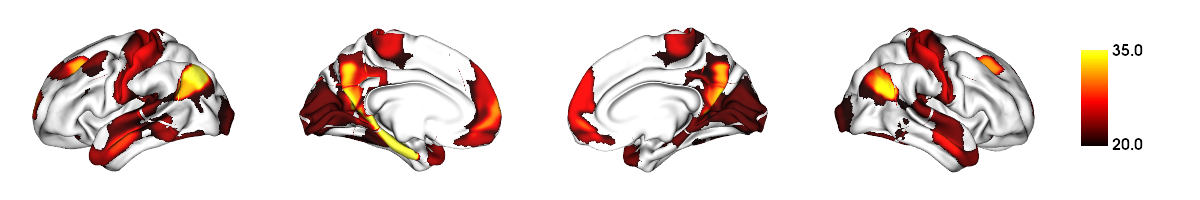

In [4]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = Tsmoo,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = plot_funcs.hotcolors,
                 color_bar = True,
                 color_range = (20, 35),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/Tvals_cortex_LSUB.svg'
                 )

### LCA - cortex

In [5]:
fname = '../data/tout_group/Tvals_cortex709_LCA.h5'

h = h5py.File((fname), 'r')
Tdata = np.array(h['data'])
h.close()

Tdata = Tdata.reshape(Tdata.shape[1],)

Tsmoo = mesh_smooth(Tdata.reshape(len(Tdata),1).T, D, 3)
Tsmoo = Tsmoo.reshape(Tsmoo.shape[1],)

Tsmoo[Tsmoo<20] = np.nan
Tsmoo[np.where(mymask == False)] = np.nan

print(Tsmoo.shape)

(64984,)


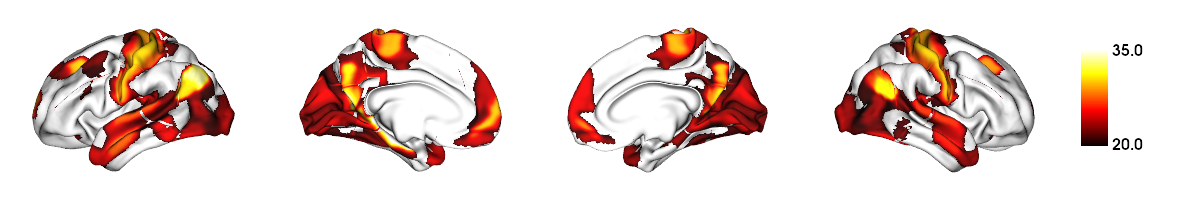

In [6]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = Tsmoo,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'hot',
                 color_bar = True,
                 color_range = (20, 35),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/Tvals_cortex_LCA.svg'
                 )

### LDG - cortex

In [7]:
fname = '../data/tout_group/Tvals_cortex709_LDG.h5'

h = h5py.File((fname), 'r')
Tdata = np.array(h['data'])
h.close()

Tdata = Tdata.reshape(Tdata.shape[1],)

Tsmoo = mesh_smooth(Tdata.reshape(len(Tdata),1).T, D, 3)
Tsmoo = Tsmoo.reshape(Tsmoo.shape[1],)

Tsmoo[Tsmoo<20] = np.nan
Tsmoo[np.where(mymask == False)] = np.nan

print(Tsmoo.shape)

(64984,)


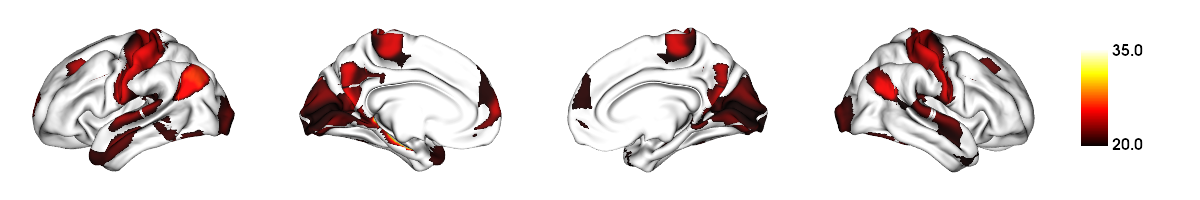

In [8]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = Tsmoo,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'hot', 
                 color_bar = True,
                 color_range = (20, 35),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/Tvals_cortex_LDG.svg'
                 )


## Heritability of hippocampal-isocortical functional connectivity


In [9]:
def FDR_sofie(p, q):
    # p : 1D np array, vector of p-values
    # q : float, false discovery rate level
    p = np.sort(p)
    V = len(p)
    I = np.arange(1,V+1)

    cVID = 1
    cVN  = (1 / np.arange(1,V+1)).sum()

    pID  = p[np.max(np.where(p <= (I / V*q / cVID)))]
    pN   = np.where(p <= (I / V*q / cVN))
    
    return pID, pN


### LSUB - cortex FC heritability

In [10]:
tot_node_num = 360
node_str = []
for i in range(1, tot_node_num+1):
    node_str.append(i)
print(len(node_str))
node_str[0], '...', node_str[-1]

360


(1, '...', 360)

In [11]:
fname = '../solar/cortex_LSUB/CLSUB_results_herit.txt'

data = pd.read_csv(fname,
                   index_col = 0,
                   header = 0)

data.index.name = 'node'

df_data_herit = pd.DataFrame(index = node_str,
                             columns = ['H2r', 'rp'])


for nodeID in range(1, tot_node_num + 1):

    iA = data.index.get_loc(nodeID)
    iB = df_data_herit.index.get_loc(nodeID)

    df_data_herit.iloc[iB]['H2r'] = data.iloc[iA]['H2r']
    df_data_herit.iloc[iB]['rp']  = data.iloc[iA]['rp']



In [12]:
# FDR correction on p-values
H =  np.array(df_data_herit['H2r'], dtype = 'float')
p = np.array(df_data_herit['rp'], dtype = 'float')
q = 0.05
pID, pN = FDR_sofie(p, q)
pID, len(np.where(p <= pID)[0])

(0.0445605, 340)

In [13]:
# map H- and p-values to fsaverage
HSUB_labeled = map_to_labels(H, labeling, mask=mymask) 
HSUB_labeled_smo = mesh_smooth(HSUB_labeled.reshape(len(HSUB_labeled),1).T, D, 2)

HSUB_labeled[np.where(mymask == False)] = np.nan
HSUB_labeled_smo = HSUB_labeled_smo.reshape(HSUB_labeled_smo.shape[1],)
HSUB_labeled_smo[np.where(mymask == False)] = np.nan

pSUB_labeled = map_to_labels(p, labeling, mask=mymask) 
pSUB_labeled[np.where(mymask == False)] = np.nan

HSUB_labeled.shape, pSUB_labeled.shape, np.nanmin(HSUB_labeled), np.nanmax(HSUB_labeled)


((64984,), (64984,), 0.0322339, 0.49572879999999997)

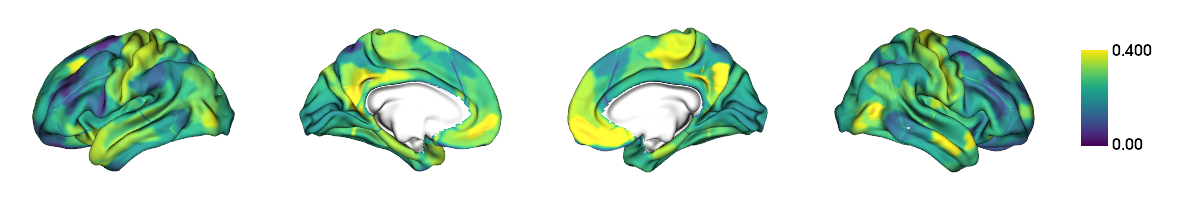

In [14]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = HSUB_labeled_smo,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'viridis', 
                 color_bar = True,
                 color_range = (0, 0.4),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/cortex_herit_LSUB_smo.svg'
                 )


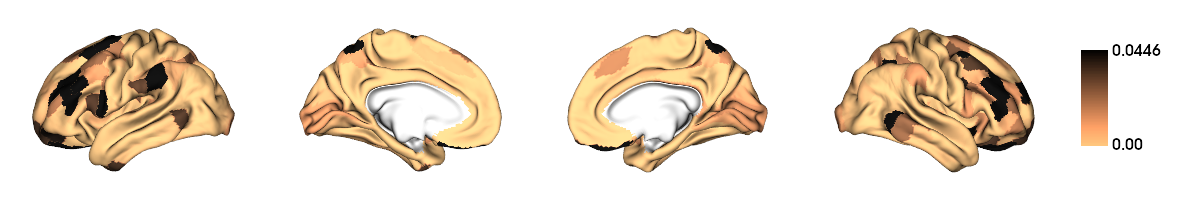

In [15]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = pSUB_labeled,
                 nan_color = (0.9,0.9,0.9,1), size = (1200, 200), cmap = 'copper_r',
                 color_bar = True, color_range = (0, pID), interactive = False,  zoom = 1.3,  embed_nb = True)



### LCA - cortex FC heritability

In [16]:
fname = '../solar/cortex_LCA/CLCA_results_herit.txt'
data = pd.read_csv(fname,
                   index_col = 0,
                   header = 0)
data.index.name = 'node'

In [17]:
df_data_herit = pd.DataFrame(index = node_str,
                             columns = ['H2r', 'rp'])

for nodeID in range(1, tot_node_num + 1):

    iA = data.index.get_loc(nodeID)
    iB = df_data_herit.index.get_loc(nodeID)

    df_data_herit.iloc[iB]['H2r'] = data.iloc[iA]['H2r']
    df_data_herit.iloc[iB]['rp']  = data.iloc[iA]['rp']


In [18]:
# FDR correction on p-values
H =  np.array(df_data_herit['H2r'], dtype = 'float')
p = np.array(df_data_herit['rp'], dtype = 'float')
q = 0.05
pID, pN = FDR_sofie(p, q)
pID, len(np.where(p <= pID)[0])


(0.0446693, 351)

In [19]:
HCA_labeled = map_to_labels(H, labeling, mask=mymask) 
HCA_labeled_smo = mesh_smooth(HCA_labeled.reshape(len(HCA_labeled),1).T, D, 2)
HCA_labeled_smo = HCA_labeled_smo.reshape(HCA_labeled_smo.shape[1],)

HCA_labeled[np.where(mymask == False)] = np.nan
HCA_labeled_smo[np.where(mymask == False)] = np.nan

pCA_labeled = map_to_labels(p, labeling, mask=mymask) 
pCA_labeled[np.where(mymask == False)] = np.nan

HCA_labeled.shape, pCA_labeled.shape, np.nanmin(HCA_labeled), np.nanmax(HCA_labeled)


((64984,), (64984,), 0.06958500000000001, 0.5246314000000001)

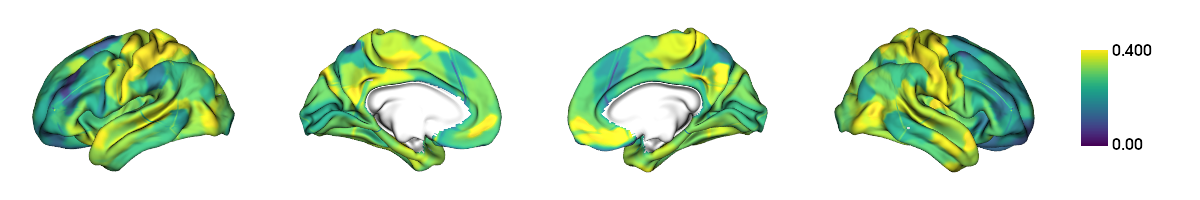

In [20]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = HCA_labeled_smo,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'viridis', 
                 color_bar = True,
                 color_range = (0, 0.4),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/cortex_herit_LCA_smoo.svg'
                 )

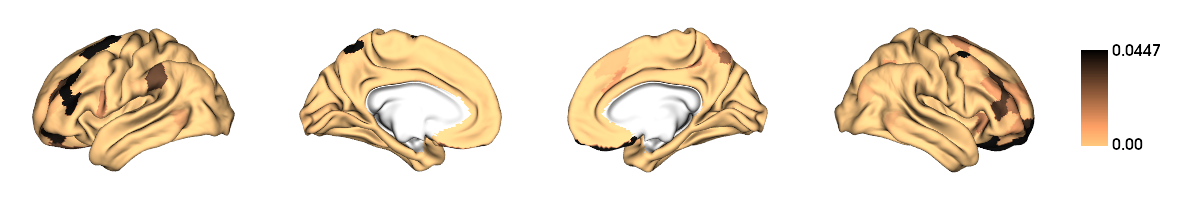

In [21]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = pCA_labeled,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'copper_r', 
                 color_bar = True,
                 color_range = (0, pID),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/cortex_herit_LCA_pvals.svg'
                 )

### LDG - cortex FC heritability

In [22]:
fname = '../solar/cortex_LDG/CLDG_results_herit.txt'

data = pd.read_csv(fname,
                   index_col = 0,
                   header = 0)

data.index.name = 'node'


In [23]:
df_data_herit = pd.DataFrame(index = node_str,
                             columns = ['H2r', 'rp'])

for nodeID in range(1, tot_node_num + 1):

    iA = data.index.get_loc(nodeID)
    iB = df_data_herit.index.get_loc(nodeID)

    df_data_herit.iloc[iB]['H2r'] = data.iloc[iA]['H2r']
    df_data_herit.iloc[iB]['rp']  = data.iloc[iA]['rp']


In [24]:
# FDR correction on p-values
H =  np.array(df_data_herit['H2r'], dtype = 'float')
p = np.array(df_data_herit['rp'], dtype = 'float')
q = 0.05
pID, pN = FDR_sofie(p, q)
pID, len(np.where(p <= pID)[0])


(0.045503800000000004, 358)

In [25]:
HDG_labeled = map_to_labels(H, labeling, mask=mymask) 
HDG_labeled_smo = mesh_smooth(HDG_labeled.reshape(len(HDG_labeled),1).T, D, 2)
HDG_labeled_smo = HDG_labeled_smo.reshape(HDG_labeled_smo.shape[1],)

HDG_labeled[np.where(mymask == False)] = np.nan
HDG_labeled_smo[np.where(mymask == False)] = np.nan

pDG_labeled = map_to_labels(p, labeling, mask=mymask) 
pDG_labeled[np.where(mymask == False)] = np.nan

HDG_labeled.shape, pDG_labeled.shape, np.nanmin(HDG_labeled), np.nanmax(HDG_labeled)


((64984,), (64984,), 0.0634892, 0.5007803)

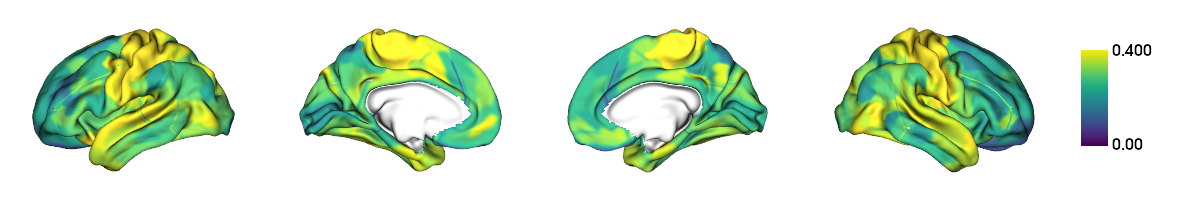

In [26]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = HDG_labeled_smo,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'viridis', 
                 color_bar = True,
                 color_range = (0, 0.4),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/cortex_herit_LDG_smo.svg'
                 )

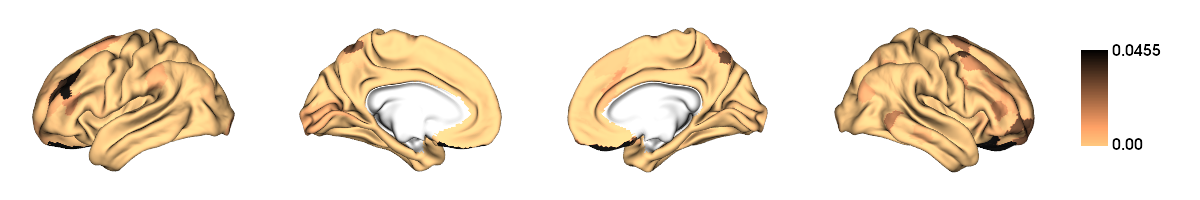

In [27]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = pDG_labeled,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'copper_r', 
                 color_bar = True,
                 color_range = (0, pID),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/cortex_herit_LDG_pvals.svg'
                 )